In [2]:
import pandas as pd

file_path = "C:/Users/User/UKM - Nur Azlin Binti Rusnan/Sem 3/Capstone Project/Dataset/2. Predictive Modeling Dataset/PM 7-1/PM-8.xlsx"

#read the excel file
xls = pd.ExcelFile(file_path)

#displat sheet name
xls.sheet_names

# load
df = pd.read_excel(xls, sheet_name="Sheet1")

df.head()

,Number,City,Country,Region,Average Response (calculated),USS Comment,String value,Sentiment,Updated,Year,Month-Year,Language,SA_Predicted Sentiment,Confidence
0,INC19299231,Midrand,South Africa,EAME,1,speedy and excellent followup and communicatio...,Very Satisfied,Positive,2024-11-01 08:40:00,2024,November,english,Positive,0.928918
1,INC19296281,Guyancourt,France,EAME,1,problem fixed quickly. thank you,Very Satisfied,Positive,2024-11-01 10:32:00,2024,November,english,Positive,0.938008
2,INC19300529,Didsbury,United Kingdom,EAME,1,malcolm did a great job in problem solving and...,Very Satisfied,Positive,2024-11-01 14:10:00,2024,November,english,Positive,0.930640
3,INC19300258,Bracknell,United Kingdom,EAME,1,thanks for the swift and awesome support and f...,Very Satisfied,Positive,2024-11-01 15:03:00,2024,November,english,Positive,0.935296
4,INC19301011,Didsbury,United Kingdom,EAME,1,great support from malcolm as usual,Very Satisfied,Positive,2024-11-01 16:40:00,2024,November,english,Positive,0.929943


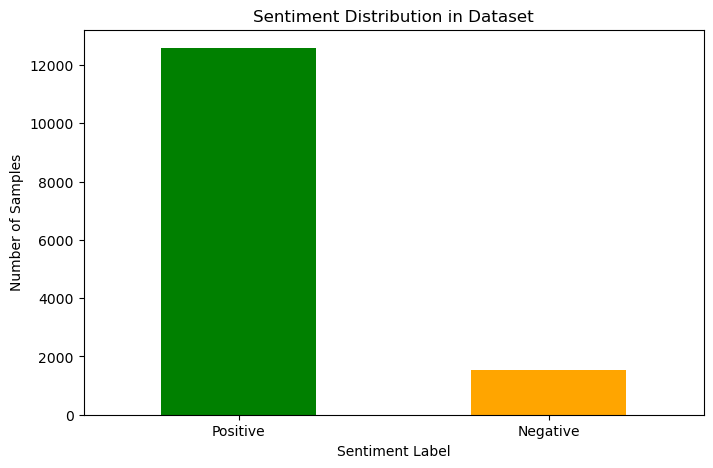

Sentiment
Positive    12582
Negative     1522
Name: count, dtype: int64

In [3]:
# check for sentiment distribution

import matplotlib.pyplot as plt

sentiment_counts = df["Sentiment"].value_counts()

#plot
plt.figure(figsize=(8,5))
sentiment_counts.plot(kind="bar", color=["green","orange","red"])
plt.title("Sentiment Distribution in Dataset")
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

# Display class distribution counts
sentiment_counts

#### **The dataset is highly imbalanced, positive = 89% and negative = 11%**

In [4]:
# balance the dataset using oversampling (Oversample negative class (duplicate to match positive samples))

from sklearn.utils import resample

#keep only relevant columns
df = df[["USS Comment", "Sentiment"]].dropna()

# Convert sentiment labels to numerical values
sentiment_mapping = {"Positive": 0, "Negative":1}
df["label"] = df["Sentiment"].map(sentiment_mapping)

# separate majority and minority classes
df_positive = df[df["label"] == 0]
df_negative = df[df["label"] == 1]

# Oversample negative class (duplicate to match positive samples)
df_negative_oversampled = resample(df_negative, replace=True, n_samples=len(df_positive), random_state=42)

# Combine balanced dataset
df_balanced = pd.concat([df_positive, df_negative_oversampled])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
balanced_counts = df_balanced["label"].value_counts()

# Display new class distribution
df_balanced.head()

,USS Comment,Sentiment,label
0,did not bring me what i wanted,Negative,1
1,i did work moving pieces from one workstation ...,Negative,1
2,issue not solved,Negative,1
3,long time reaction big rush close ticket witho...,Negative,1
4,closed without any visitation by local support...,Negative,1


In [5]:
balanced_counts

label
1    12582
0    12582
Name: count, dtype: int64

In [8]:
# Tokenizing the dataset

from transformers import AutoTokenizer
import torch


# Load pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text data
tokens = tokenizer(
    df_balanced["USS Comment"].tolist(),
    padding=True,           # Ensures uniform length for all inputs
    truncation=True,        # Truncate longer inputs to fit model max length
    max_length=128,         # Max token length for BERT
    return_tensors="pt"     # Return as PyTorch tensors
)

# Convert labels to tensor format
labels = torch.tensor(df_balanced["label"].tolist())

# Check tokenized data shape
tokens["input_ids"].shape, labels.shape


(torch.Size([25164, 128]), torch.Size([25164]))

In [9]:
# Fine-tune BERT for sentiment classification

# Step 1: Prepare the Dataset for Training
#Before training, you need to:

#Convert your dataset into a PyTorch Dataset format.
#Split it into training and validation sets.

from torch.utils.data import Dataset, DataLoader, random_split

# Custom PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create dataset
dataset = SentimentDataset(tokens, labels)

# Split into train (80%) and validation (20%) sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 20131, Validation samples: 5033


In [10]:
# Step 2: Load Pre-Trained BERT for Fine-Tuning

from transformers import AutoModelForSequenceClassification

# Load pre-trained BERT with classification head (2 classes: Positive & Negative)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 3: Define Training Parameters
#You need to specify:

#The learning rate.
#The optimizer (AdamW).
#The training schedule (number of epochs, evaluation steps, etc.).

from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)


C:\Users\User\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# 🔹 Step 4: Train the Model
# Use the Hugging Face Trainer to fine-tune the model.

from transformers import Trainer, DataCollatorWithPadding

# Use a data collator for padding dynamically
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start training
trainer.train()

C:\Users\User\AppData\Local\Temp\ipykernel_2076\3721190410.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.019300,0.077636
2,0.000600,0.047199
3,0.000100,0.029443


TrainOutput(global_step=3777, training_loss=0.049319805064608965, metrics={'train_runtime': 13391.5967, 'train_samples_per_second': 4.51, 'train_steps_per_second': 0.282, 'total_flos': 3972516491589120.0, 'train_loss': 0.049319805064608965, 'epoch': 3.0})

In [13]:
# Step 5: Save fine-tuned model
model.save_pretrained("./bert_sentiment_model_llm")
tokenizer.save_pretrained("./bert_sentiment_model_llm")

print("Fine-tuned model saved!")


Fine-tuned model saved!


In [14]:
# 6: 1. Evaluate Using the Trainer

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print("Evaluation results:")
print(eval_results)


Evaluation results:
{'eval_loss': 0.029443344101309776, 'eval_runtime': 298.7789, 'eval_samples_per_second': 16.845, 'eval_steps_per_second': 1.054, 'epoch': 3.0}


In [15]:
# 2. Generate Predictions for Sample Inputs

def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Map numerical labels back to sentiment strings
    label_mapping = {0: "Positive", 1: "Negative"}
    return label_mapping[prediction]

# Test the model with a few example texts
test_texts = [
    "The support team was very helpful and solved my issue quickly!",
    "I am not happy with the service; it took too long and was unresponsive."
]

for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


Text: The support team was very helpful and solved my issue quickly!
Predicted Sentiment: Positive

Text: I am not happy with the service; it took too long and was unresponsive.
Predicted Sentiment: Negative



In [16]:
# 3. Compute Detailed Classification Metrics
from sklearn.metrics import classification_report

# Get predictions on the entire validation dataset
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
for batch in val_loader:
    # Move inputs to the same device as model (if using GPU)
    inputs = {key: value for key, value in batch.items() if key != "labels"}
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1)
    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

# Print the classification report
report = classification_report(all_labels, all_preds, target_names=["Positive", "Negative"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Positive       1.00      0.99      1.00      2499
    Negative       0.99      1.00      1.00      2534

    accuracy                           1.00      5033
   macro avg       1.00      1.00      1.00      5033
weighted avg       1.00      1.00      1.00      5033



In [18]:
# Deploying Sentiment Analysis Chatbot in Jupyter Notebook

# ✅ Step 1: Load the Fine-Tuned Model

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load fine-tuned model and tokenizer
model_path = "./bert_sentiment_model_llm"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Set model to evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
# ✅ Step 2: Create a Sentiment Prediction Function

def predict_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Map numerical labels back to sentiment labels
    sentiment_mapping = {0: "Positive 😊", 1: "Negative 😞"}
    return sentiment_mapping[prediction]


In [20]:
# ✅ Step 3: Create an Interactive Chatbot in Jupyter Notebook

import ipywidgets as widgets
from IPython.display import display

# Create input field and output display
text_input = widgets.Text(placeholder="Enter your feedback...")
output = widgets.Output()

def on_submit(_):
    with output:
        output.clear_output()
        sentiment = predict_sentiment(text_input.value)
        print(f"Predicted Sentiment: {sentiment}")

# When user presses Enter, process input
text_input.on_submit(on_submit)

# Display chatbot UI
display(text_input, output)


Text(value='', placeholder='Enter your feedback...')

Output()